In [1]:
using Distributed
using SharedArrays
addprocs(11);

In [2]:
@everywhere include("inverse_prob.jl")
@everywhere using PyPlot, JLD2, DSP

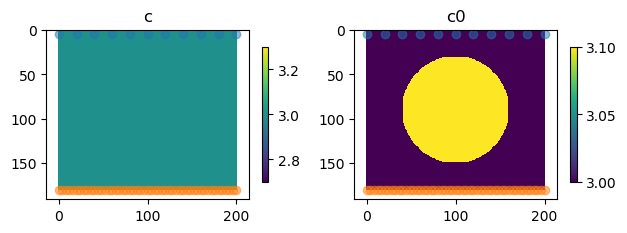

In [3]:
@eval @everywhere begin
    Nx = 181;
    Ny = 201;
    h = 0.01;
    x = range(0,step=h,length=Nx)
    y = range(0,step=h,length=Ny)

    Fs = 1000;
    dt = 1/Fs
    Nt = 1200;
    t = range(0, length=Nt, step=dt)
    t0 = range(0, length=2000, step=dt)

    source = source_ricker(10, 0.15, t0)
    responsetype = Highpass(3; fs=Fs)
    designmethod = FIRWindow(hanning(1024-1))
    ss = filt(digitalfilter(responsetype, designmethod), -source);
    source = ss[512:512+1200-1]
    source = source./ maximum(source)

    source_position = zeros(11,2)
    for i = 1:11
        source_position[i,:] = [5,20*(i-1)+1]
    end
    source = repeat(source, 1, 11)

    receiver_position = zeros(51,2)
    for i = 1:51
        receiver_position[i,:] = [181,(i-1)*4+1]
    end

    c0 = 3*ones(Nx, Ny)
    rho0 = ones(Nx, Ny)
    for i = 1:Nx
        for j = 1:Ny
            if sqrt((x[i]-0.9).^2 + (y[j]-1).^2) < 0.6
                c0[i,j] = 3.1
            end
        end
    end
    
    c = 3*ones(Nx, Ny)
#     c[1:end,:] = imfilter(c0[1:end,:], Kernel.gaussian(20));
    rho = ones(Nx, Ny);
end
figure
subplot(121)
imshow(c); colorbar(shrink=0.3); title("c"); 
scatter(source_position[:,2].-1, source_position[:,1].-1, alpha=0.5)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1, alpha=0.5)
subplot(122)
imshow(c0); colorbar(shrink=0.3); title("c0"); 
scatter(source_position[:,2].-1, source_position[:,1].-1, alpha=0.5)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1, alpha=0.5)
tight_layout()

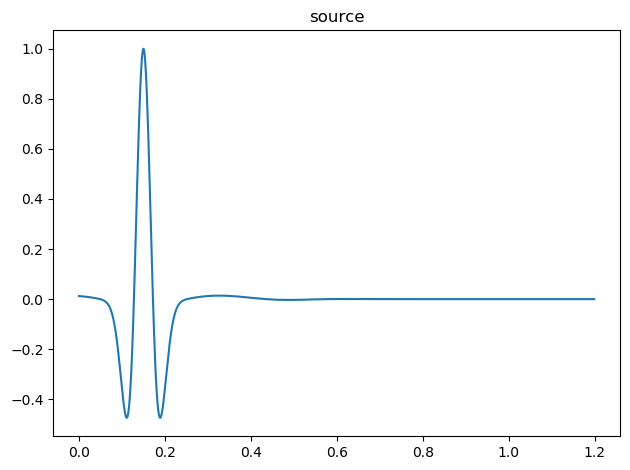

In [4]:
plot(t,source[:,1]); title("source"); tight_layout()

In [5]:
save_ratio = 12;
pml_len = 30;
pml_coef = 100;

@time data, u = multi_solver_parallel(c, rho, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=pml_len, pml_coef=pml_coef, save_ratio=save_ratio);
@time data0, u0 = multi_solver_parallel(c0, rho0, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=pml_len, pml_coef=pml_coef, save_ratio=save_ratio);


 40.045197 seconds (8.83 M allocations: 437.819 MiB, 0.37% gc time)
 25.631624 seconds (12.79 k allocations: 598.454 KiB)


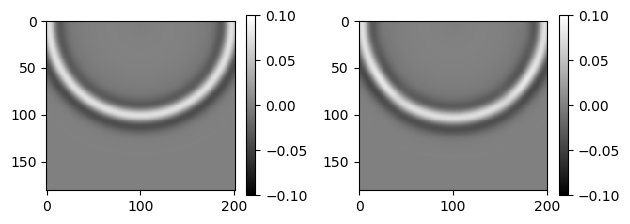

In [6]:
figure;
time_ind = 40
subplot(121); imshow(u[:,:,time_ind,6],cmap=ColorMap("gray")); colorbar(shrink=0.4); clim(-0.1,0.1)
subplot(122); imshow(u0[:,:,time_ind,6],cmap=ColorMap("gray")); colorbar(shrink=0.4); clim(-0.1,0.1)
tight_layout()

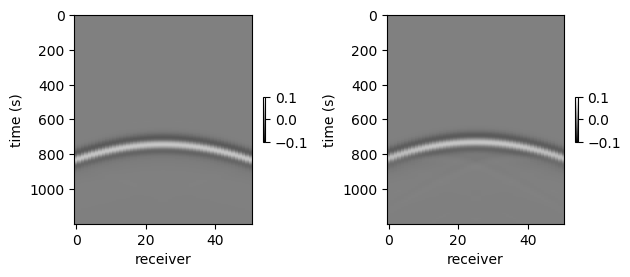

In [7]:
figure;
subplot(121); imshow(data[:,:,6],cmap=ColorMap("gray"), aspect=0.05); colorbar(shrink=0.1); clim([-0.1,0.1])
xlabel("receiver"); ylabel("time (s)")
subplot(122); imshow(data0[:,:,6],cmap=ColorMap("gray"), aspect=0.05); colorbar(shrink=0.1); clim([-0.1,0.1])
xlabel("receiver"); ylabel("time (s)")
tight_layout()

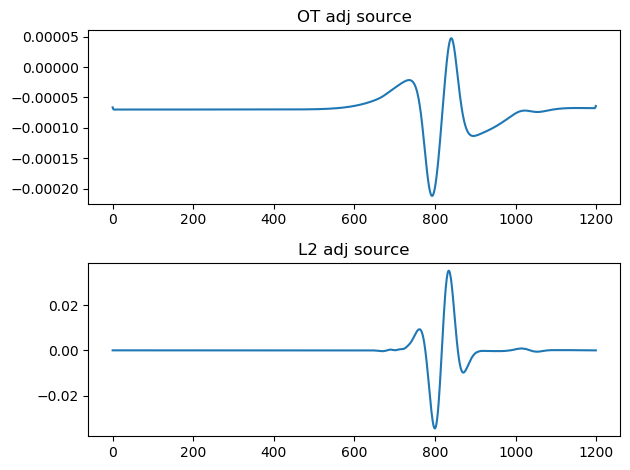

In [8]:
M = cost_matrix_1d(t,t; p=2)
reg = 1e-5
reg_m = 1e0
reg_p = 0.1
iterMax = 1000;

f = data[:,30,2] .+ reg_p
g = data0[:,30,2] .+ reg_p

TT,gg,dd = unbalanced_sinkhorn_1d(f, g, M, reg, reg_m; iterMax=iterMax);
subplot(211); plot(gg); title("OT adj source")
subplot(212); plot(f-g); title("L2 adj source")
tight_layout()

# Save data

In [9]:
@save "camembert_data/camembert_model.jld2" c c0 rho Nx Ny Nt h t dt source source_position receiver_position save_ratio pml_len pml_coef

In [10]:
@save "camembert_data/camembert_data.jld2" data data0